In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, label_binarize, OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot as plt
import numpy as np
import mlflow
import mlflow.sklearn


import dagshub
dagshub.init(repo_owner='empleo-inducido', repo_name='project-ml', mlflow=True)
mlflow.autolog()

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e210f973-e018-4aa0-979d-0edc58d14ef8&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6bb5be6e7948c99c1331a97d6008e35742d0083c08ea99f8ea1a2e51900b6a5f




Initialized MLflow to track repo "empleo-inducido/project-ml"

Repository empleo-inducido/project-ml initialized!

2024/05/30 09:39:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [2]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
scaler = StandardScaler()

In [7]:
#Datos de entrenamiento
train = pd.read_csv('/home/project/data/processed/train/train-dengue.csv')
#Preprocesar datos de entrenamiento
X_train = train.drop('TIPO_PACIENTE', axis=1)
y_train = train['TIPO_PACIENTE']

encoded_columns  = encoder.fit_transform(X_train[['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR']])
scaled_columns = scaler.fit_transform(X_train.drop(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], axis=1))

encoded_scaled_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR']))
scaled_df = pd.DataFrame(scaled_columns, columns=X_train.drop(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], axis=1).columns)
X_train = pd.concat([encoded_scaled_df, scaled_df], axis=1)

#Datos de Prueba
test = pd.read_csv('/home/project/data/processed/test/test-dengue.csv')
# Preprocesar datos de prueba
X_test = test.drop('TIPO_PACIENTE', axis=1)
y_test = test['TIPO_PACIENTE']

encoded_columns  = encoder.transform(X_test[['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR']])
scaled_columns = scaler.transform(X_test.drop(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], axis=1))

encoded_scaled_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR']))
scaled_df = pd.DataFrame(scaled_columns, columns=X_test.drop(['SEXO', 'ESTATUS_CASO', 'RESULTADO_PCR'], axis=1).columns)
X_test = pd.concat([encoded_scaled_df, scaled_df], axis=1)

# Convertir nombres de columnas a string
X_test_df = pd.DataFrame(X_test, columns=[str(i) for i in range(X_test.shape[1])])
X_test_df['TIPO_PACIENTE'] = y_test.values

# Guardar los datos preprocesados
X_test_df.to_parquet('processed_test_data.parquet')

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
import joblib
joblib.dump(encoder, '/home/project/models/preprocess_utils/encoder.pkl')
joblib.dump(scaler, '/home/project/models/preprocess_utils/scaler.pkl')

['/home/project/models/preprocess_utils/scaler.pkl']

2024/05/27 07:04:47 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/05/27 07:05:25 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.
2024/05/27 07:05:27 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2024/05/27 07:05:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID cb5a75c8402747eb8e952c8bdce93e23. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Response: {\'error_code\': \'INVALID_PARAMETER_VALUE\'}")]')]


Accuracy: 0.8023162939297125
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.96      0.88      7892
           2       0.60      0.21      0.31      2124

    accuracy                           0.80     10016
   macro avg       0.71      0.59      0.60     10016
weighted avg       0.77      0.80      0.76     10016



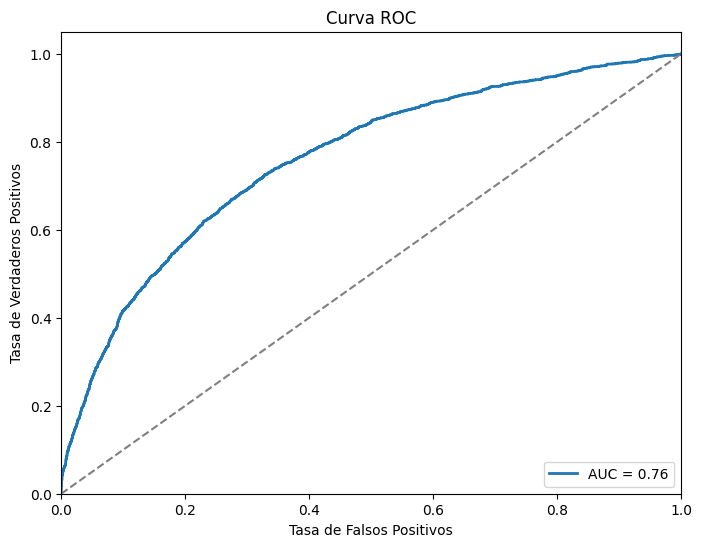

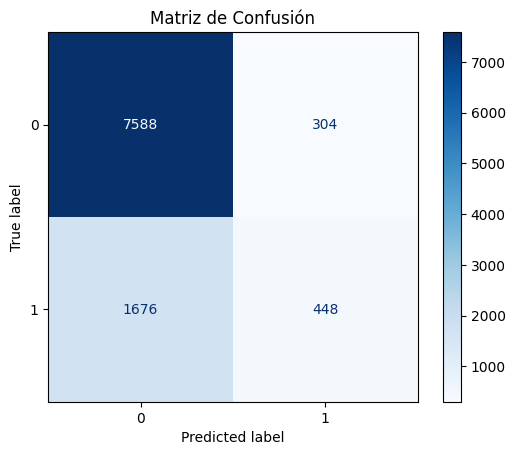

In [4]:
with mlflow.start_run(run_name='bagging'):
    # Modelo de regresión logística
    model = LogisticRegression(max_iter=1000)

    # Ajuste de hiperparámetros
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Ejemplo de valores para ajustar
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Mejor modelo encontrado
    best_model = grid_search.best_estimator_

    # Bagging
    bagging_model = BaggingClassifier(best_model, n_estimators=10, random_state=42)
    bagging_model.fit(X_train, y_train)
    
    # Predicción en el conjunto de prueba
    y_pred = bagging_model.predict(X_test)
    y_prob = bagging_model.predict_proba(X_test)

    # Evaluación del modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)
    
    # Extraer solo las probabilidades positivas
    y_prob_positive = y_prob[:, 1]

    # Binarizar las etiquetas de clase
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Calcular la curva ROC y el área bajo la curva para cada clase
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.show()
    
    mlflow.end_run()